In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"

In [4]:
class_names = [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]
image_paths = []
labels = []

for class_name in class_names:
    class_dir = covid_19 / class_name / 'images'
    if os.path.exists(class_dir):
        file_names = [f_name for f_name in os.listdir(class_dir) if f_name.endswith((".jpeg", ".png"))]

        for f_name in tqdm(file_names, desc=f"Processing {class_name}"):
            image_paths.append(os.path.join(class_dir, f_name))
            labels.append(class_name)

Processing COVID: 100%|██████████| 3616/3616 [00:00<00:00, 574449.03it/s]


In [5]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [6]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [7]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 21165/21165 [00:16<00:00, 1292.16it/s]

             Class  Black & White  Colored
0           Normal          10192        0
1     Lung_Opacity           6012        0
2  Viral Pneumonia           1205      140
3            COVID           3616        0


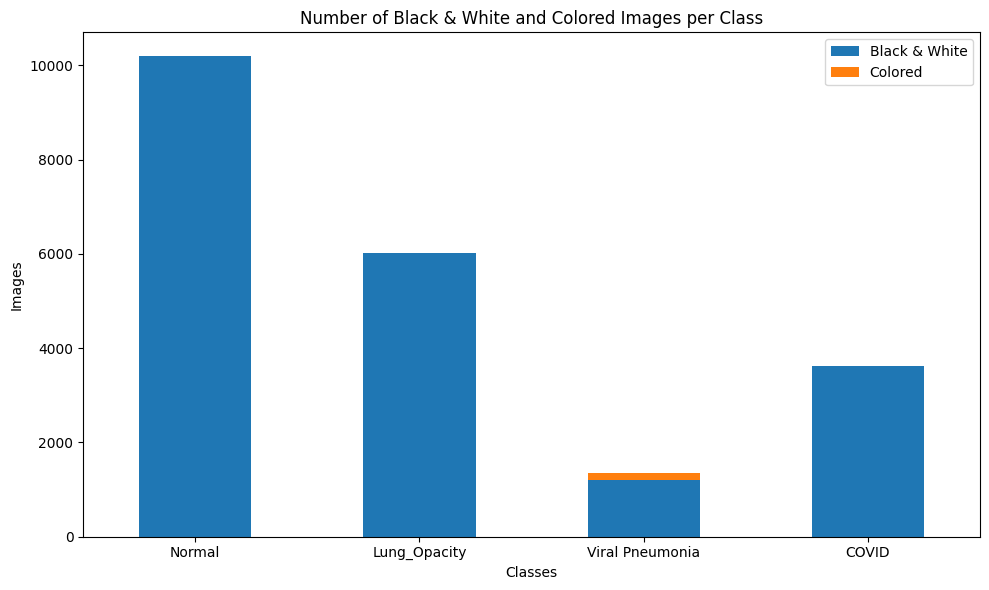

In [8]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 4/4 [00:00<00:00, 133.91it/s]


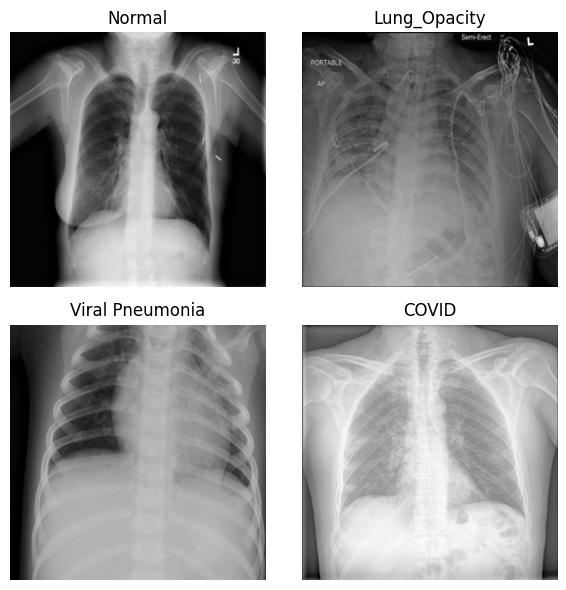

In [9]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols, i % num_cols]
                ax.imshow(selected_image, cmap='gray')
                ax.set_title(class_label)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 4/4 [00:36<00:00,  9.17s/it]


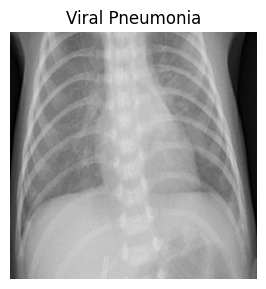

In [10]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [11]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

# First: split off the test set (10% of the total)
remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths,
    labels_encoded,
    test_size=0.1,
    random_state=42,
    stratify=labels_encoded
)

# Second: from the remaining 90%, split off the validation set.
# To have validation = 10% of the total, we use test_size = 0.1 / 0.9 ≈ 0.1111 here.
train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths,
    remaining_labels,
    test_size=0.1111,
    random_state=42,
    stratify=remaining_labels
)

# Calculate total counts and percentages
total_samples = len(labels_encoded)
total_train_samples = len(train_paths)
total_val_samples = len(val_paths)
total_test_samples = len(test_paths)

train_percentage = (total_train_samples / total_samples) * 100
val_percentage = (total_val_samples / total_samples) * 100
test_percentage = (total_test_samples / total_samples) * 100

# Compute class distribution counts for each split
train_counts = pd.Series(train_labels).value_counts().sort_index()
val_counts = pd.Series(val_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

# Create DataFrames for reporting (assuming 'class_names' is defined)
train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})
train_df.index = val_df.index = test_df.index = class_names

# Print summary information
print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 16931
Total Validation Samples: 2117
Total Test Samples: 2117

Percentage of Split:
Train: 80.00%
Validation: 10.00%
Test: 10.00%

Class Distribution:
                 Train Samples  Validation Samples  Test Samples
Normal                    2892                 362           362
Lung_Opacity              4810                 601           601
Viral Pneumonia           8153                1020          1019
COVID                     1076                 134           135


In [12]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        pil_img = Image.fromarray(img)
        
        transformed_img = self.transform(pil_img)

        label = self.img_labels[index]
        return transformed_img, label

In [13]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [14]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dim must be divisible by number of heads."
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Query, Key, Value linear transformations
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x shape: (batch_size, seq_len, embed_dim)
        """
        B, N, C = x.shape
        
        # qkv shape: (B, N, 3C)
        qkv = self.qkv(x)
        # Split into Q, K, V, each (B, N, C)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        
        # Reshape for multi-head attention:
        # (B, N, C) -> (B, N, num_heads, head_dim) -> (B, num_heads, N, head_dim)
        q = q.reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        attn_weights = (q @ k.transpose(-2, -1)) / sqrt(self.head_dim)
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        
        out = attn_weights @ v  # (B, num_heads, N, head_dim)
        
        # Recombine heads
        out = out.transpose(1, 2).reshape(B, N, C)
        
        # Final projection
        out = self.out_proj(out)
        out = self.proj_dropout(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [15]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        
        self.ff = FeedForward(embed_dim, mlp_dim, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # --- Multi-Head Attention ---
        attn_out = self.attn(x)
        x = x + attn_out           # residual
        x = self.norm1(x)         # post-LN

        # --- MLP ---
        ff_out = self.ff(x)
        x = x + ff_out            # residual
        x = self.norm2(x)         # post-LN

        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=224,
        patch_size=16,
        num_classes=2,           # Binary classification: Normal vs. Pneumonia
        in_channels=1,           # 1 for grayscale X-ray; 3 for RGB
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_dim=3072,
        dropout=0.1
    ):
        super().__init__()
        
        assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        # Linear projection for flattened patches
        self.patch_embed = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        
        # Learnable class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Positional embeddings (one for each patch + 1 for [class] token)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
        self.pos_drop = nn.Dropout(dropout)
        
        # Stacked transformer encoder blocks (post-LN)
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])
        
        # Optionally, a final layer norm (ViT often includes it)
        self.final_norm = nn.LayerNorm(embed_dim)
        
        # MLP head for classification
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Weight initialization
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.normal_(self.pos_embed, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.zeros_(m.bias)
                nn.init.ones_(m.weight)
    
    def forward(self, x):
        """
        x shape: (batch_size, in_channels, image_size, image_size)
        """
        B, C, H, W = x.shape
        
        # 1) Split into patches
        patches = self._create_patches(x)  # (B, num_patches, patch_size*patch_size*C)
        
        # 2) Linear embedding
        x = self.patch_embed(patches)  # (B, num_patches, embed_dim)
        
        # 3) Prepend class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, 1 + num_patches, embed_dim)
        
        # 4) Add positional embeddings
        x = x + self.pos_embed[:, : x.size(1), :]
        x = self.pos_drop(x)
        
        # 5) Pass through Transformer encoder blocks (post-LN inside blocks)
        for block in self.blocks:
            x = block(x)
        
        # 6) Optional final normalization
        x = self.final_norm(x)
        
        # 7) Classification head on [class] token
        cls_output = x[:, 0]
        logits = self.head(cls_output)
        return logits

    def _create_patches(self, x):
        """
        Splits the input images into patches of size (patch_size x patch_size).
        Returns a flattened patch tensor.
        """
        B, C, H, W = x.shape
        p = self.patch_size
        
        # Unfold: (B, C*(p^2), num_patches)
        patches = x.unfold(2, p, p).unfold(3, p, p)
        # patches shape: (B, C, H/p, W/p, p, p)
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
        # Flatten the last three dimensions: (B, H/p * W/p, C*p*p)
        patches = patches.view(B, -1, C * p * p)
        return patches

In [16]:
image_size = 224           # Standard starting resolution
patch_size = 16            # Balanced for detail vs. compute
in_channels = 3            # Colored images
num_classes = 4            # Four-class classification task

model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    in_channels=in_channels,
    embed_dim=768,        # Increased embedding dimension (ViT-Base)
    depth=12,             # Increased depth (ViT-Base)
    num_heads=12,         # 768 is divisible by 12 (each head: 768/12 = 64)
    mlp_dim=3072,         # MLP dimension typically 4x embed_dim for ViT-Base
    dropout=0.1           # Standard dropout for regularization
)

model.to(device)

summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    152,064
├─Linear: 1-1                                 [1, 196, 768]             590,592
├─Dropout: 1-2                                [1, 197, 768]             --
├─ModuleList: 1-3                             --                        --
│    └─TransformerEncoderBlock: 2-1           [1, 197, 768]             --
│    │    └─MultiHeadSelfAttention: 3-1       [1, 197, 768]             2,362,368
│    │    └─LayerNorm: 3-2                    [1, 197, 768]             1,536
│    │    └─FeedForward: 3-3                  [1, 197, 768]             4,722,432
│    │    └─LayerNorm: 3-4                    [1, 197, 768]             1,536
│    └─TransformerEncoderBlock: 2-2           [1, 197, 768]             --
│    │    └─MultiHeadSelfAttention: 3-5       [1, 197, 768]             2,362,368
│    │    └─LayerNorm: 3-6                    [1, 197, 768

In [17]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [19]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    # Validation loop
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    # Step the scheduler to decay the learning rate by 0.995
    scheduler.step()

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 1059/1059 [05:20<00:00,  3.31it/s]


Metrics - loss: 1.2696, accuracy: 0.4358, precision: 0.3841, recall: 0.4358, f1_score: 0.3786, specificity: 0.0999, sensitivity: 0.9486, mcc: 0.0249, auc: 0.5352


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.18it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 1.1274, accuracy: 0.5040, precision: 0.3366, recall: 0.5040, f1_score: 0.3742, specificity: 0.2403, sensitivity: 0.9613, mcc: 0.1509, auc: 0.6699


Training Model - Epoch [2/25]: 100%|██████████| 1059/1059 [05:20<00:00,  3.30it/s]


Metrics - loss: 1.0248, accuracy: 0.5563, precision: 0.5392, recall: 0.5563, f1_score: 0.5336, specificity: 0.2050, sensitivity: 0.9471, mcc: 0.2834, auc: 0.7263


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s]


Metrics - loss: 0.8880, accuracy: 0.6349, precision: 0.6567, recall: 0.6349, f1_score: 0.5994, specificity: 0.2320, sensitivity: 0.9732, mcc: 0.4157, auc: 0.8310


Training Model - Epoch [3/25]: 100%|██████████| 1059/1059 [05:20<00:00,  3.30it/s]


Metrics - loss: 0.8290, accuracy: 0.6574, precision: 0.6451, recall: 0.6574, f1_score: 0.6445, specificity: 0.3057, sensitivity: 0.9419, mcc: 0.4612, auc: 0.8196


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.21it/s]


Metrics - loss: 0.7762, accuracy: 0.6901, precision: 0.7200, recall: 0.6901, f1_score: 0.6740, specificity: 0.4917, sensitivity: 0.9356, mcc: 0.5179, auc: 0.8789


Training Model - Epoch [4/25]: 100%|██████████| 1059/1059 [05:20<00:00,  3.30it/s]


Metrics - loss: 0.7392, accuracy: 0.6977, precision: 0.6906, recall: 0.6977, f1_score: 0.6903, specificity: 0.4184, sensitivity: 0.9370, mcc: 0.5272, auc: 0.8531


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.18it/s]


Metrics - loss: 0.6764, accuracy: 0.7454, precision: 0.7484, recall: 0.7454, f1_score: 0.7397, specificity: 0.5470, sensitivity: 0.9436, mcc: 0.6053, auc: 0.8794


Training Model - Epoch [5/25]: 100%|██████████| 1059/1059 [05:20<00:00,  3.30it/s]


Metrics - loss: 0.6701, accuracy: 0.7309, precision: 0.7269, recall: 0.7309, f1_score: 0.7266, specificity: 0.5242, sensitivity: 0.9390, mcc: 0.5812, auc: 0.8764


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.17it/s]


Metrics - loss: 0.6252, accuracy: 0.7496, precision: 0.7641, recall: 0.7496, f1_score: 0.7391, specificity: 0.4475, sensitivity: 0.9835, mcc: 0.6134, auc: 0.9107


Training Model - Epoch [6/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.5911, accuracy: 0.7668, precision: 0.7650, recall: 0.7668, f1_score: 0.7643, specificity: 0.6286, sensitivity: 0.9484, mcc: 0.6384, auc: 0.9005


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.20it/s]


Metrics - loss: 0.6001, accuracy: 0.7770, precision: 0.7959, recall: 0.7770, f1_score: 0.7803, specificity: 0.8315, sensitivity: 0.8781, mcc: 0.6676, auc: 0.9155


Training Model - Epoch [7/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.5611, accuracy: 0.7795, precision: 0.7780, recall: 0.7795, f1_score: 0.7779, specificity: 0.6777, sensitivity: 0.9481, mcc: 0.6592, auc: 0.9098


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s]


Metrics - loss: 0.5736, accuracy: 0.7803, precision: 0.7923, recall: 0.7803, f1_score: 0.7738, specificity: 0.5856, sensitivity: 0.9761, mcc: 0.6624, auc: 0.9185


Training Model - Epoch [8/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.5227, accuracy: 0.8024, precision: 0.8016, recall: 0.8024, f1_score: 0.8010, specificity: 0.7244, sensitivity: 0.9540, mcc: 0.6951, auc: 0.9204


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.20it/s]


Metrics - loss: 0.5275, accuracy: 0.7950, precision: 0.8075, recall: 0.7950, f1_score: 0.7975, specificity: 0.8536, sensitivity: 0.9003, mcc: 0.6966, auc: 0.9314


Training Model - Epoch [9/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.4890, accuracy: 0.8077, precision: 0.8071, recall: 0.8077, f1_score: 0.8066, specificity: 0.7569, sensitivity: 0.9572, mcc: 0.7037, auc: 0.9274


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.18it/s]


Metrics - loss: 0.4914, accuracy: 0.8040, precision: 0.8114, recall: 0.8040, f1_score: 0.8057, specificity: 0.8232, sensitivity: 0.9208, mcc: 0.7049, auc: 0.9351


Training Model - Epoch [10/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.4504, accuracy: 0.8274, precision: 0.8270, recall: 0.8274, f1_score: 0.8263, specificity: 0.7981, sensitivity: 0.9631, mcc: 0.7344, auc: 0.9371


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.21it/s]


Metrics - loss: 0.4719, accuracy: 0.8200, precision: 0.8227, recall: 0.8200, f1_score: 0.8199, specificity: 0.8066, sensitivity: 0.9368, mcc: 0.7241, auc: 0.9418


Training Model - Epoch [11/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.4183, accuracy: 0.8398, precision: 0.8394, recall: 0.8398, f1_score: 0.8389, specificity: 0.8195, sensitivity: 0.9669, mcc: 0.7536, auc: 0.9433


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.17it/s]


Metrics - loss: 0.5315, accuracy: 0.8304, precision: 0.8328, recall: 0.8304, f1_score: 0.8300, specificity: 0.8370, sensitivity: 0.9470, mcc: 0.7395, auc: 0.9539


Training Model - Epoch [12/25]: 100%|██████████| 1059/1059 [05:20<00:00,  3.30it/s]


Metrics - loss: 0.3945, accuracy: 0.8497, precision: 0.8496, recall: 0.8497, f1_score: 0.8490, specificity: 0.8389, sensitivity: 0.9708, mcc: 0.7690, auc: 0.9512


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s]


Metrics - loss: 0.4179, accuracy: 0.8436, precision: 0.8449, recall: 0.8436, f1_score: 0.8421, specificity: 0.8840, sensitivity: 0.9521, mcc: 0.7620, auc: 0.9486


Training Model - Epoch [13/25]: 100%|██████████| 1059/1059 [05:20<00:00,  3.30it/s]


Metrics - loss: 0.3775, accuracy: 0.8582, precision: 0.8580, recall: 0.8582, f1_score: 0.8575, specificity: 0.8631, sensitivity: 0.9721, mcc: 0.7822, auc: 0.9502


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.18it/s]


Metrics - loss: 0.3924, accuracy: 0.8526, precision: 0.8549, recall: 0.8526, f1_score: 0.8515, specificity: 0.8536, sensitivity: 0.9744, mcc: 0.7722, auc: 0.9541


Training Model - Epoch [14/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.3577, accuracy: 0.8633, precision: 0.8629, recall: 0.8633, f1_score: 0.8627, specificity: 0.8786, sensitivity: 0.9743, mcc: 0.7902, auc: 0.9540


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.17it/s]


Metrics - loss: 0.4115, accuracy: 0.8573, precision: 0.8590, recall: 0.8573, f1_score: 0.8564, specificity: 0.8122, sensitivity: 0.9783, mcc: 0.7793, auc: 0.9531


Training Model - Epoch [15/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.3455, accuracy: 0.8706, precision: 0.8706, recall: 0.8706, f1_score: 0.8699, specificity: 0.8838, sensitivity: 0.9774, mcc: 0.8013, auc: 0.9553


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.21it/s]


Metrics - loss: 0.4086, accuracy: 0.8602, precision: 0.8615, recall: 0.8602, f1_score: 0.8601, specificity: 0.8204, sensitivity: 0.9766, mcc: 0.7843, auc: 0.9590


Training Model - Epoch [16/25]: 100%|██████████| 1059/1059 [05:20<00:00,  3.30it/s]


Metrics - loss: 0.3263, accuracy: 0.8787, precision: 0.8786, recall: 0.8787, f1_score: 0.8783, specificity: 0.8907, sensitivity: 0.9793, mcc: 0.8138, auc: 0.9612


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.17it/s]


Metrics - loss: 0.3873, accuracy: 0.8512, precision: 0.8567, recall: 0.8512, f1_score: 0.8487, specificity: 0.8343, sensitivity: 0.9744, mcc: 0.7724, auc: 0.9610


Training Model - Epoch [17/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.3045, accuracy: 0.8858, precision: 0.8856, recall: 0.8858, f1_score: 0.8852, specificity: 0.9132, sensitivity: 0.9818, mcc: 0.8248, auc: 0.9644


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.18it/s]


Metrics - loss: 0.4185, accuracy: 0.8654, precision: 0.8749, recall: 0.8654, f1_score: 0.8619, specificity: 0.9006, sensitivity: 0.9795, mcc: 0.7964, auc: 0.9591


Training Model - Epoch [18/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.2959, accuracy: 0.8874, precision: 0.8873, recall: 0.8874, f1_score: 0.8869, specificity: 0.9101, sensitivity: 0.9821, mcc: 0.8273, auc: 0.9663


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s]


Metrics - loss: 0.3899, accuracy: 0.8507, precision: 0.8648, recall: 0.8507, f1_score: 0.8472, specificity: 0.7845, sensitivity: 0.9886, mcc: 0.7745, auc: 0.9648


Training Model - Epoch [19/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.2852, accuracy: 0.8950, precision: 0.8948, recall: 0.8950, f1_score: 0.8945, specificity: 0.9215, sensitivity: 0.9833, mcc: 0.8390, auc: 0.9672


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s]


Metrics - loss: 0.3430, accuracy: 0.8696, precision: 0.8695, recall: 0.8696, f1_score: 0.8689, specificity: 0.8895, sensitivity: 0.9744, mcc: 0.7997, auc: 0.9641


Training Model - Epoch [20/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.2755, accuracy: 0.8962, precision: 0.8962, recall: 0.8962, f1_score: 0.8957, specificity: 0.9184, sensitivity: 0.9839, mcc: 0.8407, auc: 0.9700


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s]


Metrics - loss: 0.3721, accuracy: 0.8753, precision: 0.8796, recall: 0.8753, f1_score: 0.8736, specificity: 0.8867, sensitivity: 0.9886, mcc: 0.8092, auc: 0.9655


Training Model - Epoch [21/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.2606, accuracy: 0.9035, precision: 0.9035, recall: 0.9035, f1_score: 0.9033, specificity: 0.9284, sensitivity: 0.9872, mcc: 0.8521, auc: 0.9732


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.18it/s]


Metrics - loss: 0.3271, accuracy: 0.8843, precision: 0.8850, recall: 0.8843, f1_score: 0.8845, specificity: 0.8895, sensitivity: 0.9835, mcc: 0.8226, auc: 0.9709


Training Model - Epoch [22/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.29it/s]


Metrics - loss: 0.2450, accuracy: 0.9088, precision: 0.9086, recall: 0.9088, f1_score: 0.9085, specificity: 0.9440, sensitivity: 0.9882, mcc: 0.8602, auc: 0.9747


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.18it/s]


Metrics - loss: 0.3924, accuracy: 0.8739, precision: 0.8770, recall: 0.8739, f1_score: 0.8727, specificity: 0.7956, sensitivity: 0.9903, mcc: 0.8055, auc: 0.9686


Training Model - Epoch [23/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.2380, accuracy: 0.9111, precision: 0.9109, recall: 0.9111, f1_score: 0.9107, specificity: 0.9440, sensitivity: 0.9882, mcc: 0.8637, auc: 0.9757


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.20it/s]


Metrics - loss: 0.3618, accuracy: 0.8687, precision: 0.8684, recall: 0.8687, f1_score: 0.8680, specificity: 0.8978, sensitivity: 0.9692, mcc: 0.7992, auc: 0.9671


Training Model - Epoch [24/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.30it/s]


Metrics - loss: 0.2345, accuracy: 0.9129, precision: 0.9128, recall: 0.9129, f1_score: 0.9125, specificity: 0.9395, sensitivity: 0.9885, mcc: 0.8665, auc: 0.9771


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.20it/s]


Metrics - loss: 0.3395, accuracy: 0.8847, precision: 0.8868, recall: 0.8847, f1_score: 0.8843, specificity: 0.8867, sensitivity: 0.9886, mcc: 0.8223, auc: 0.9732


Training Model - Epoch [25/25]: 100%|██████████| 1059/1059 [05:21<00:00,  3.29it/s]


Metrics - loss: 0.2186, accuracy: 0.9175, precision: 0.9174, recall: 0.9175, f1_score: 0.9172, specificity: 0.9502, sensitivity: 0.9902, mcc: 0.8735, auc: 0.9796


Validating Model: 100%|██████████| 133/133 [00:13<00:00, 10.19it/s]

Metrics - loss: 0.4164, accuracy: 0.8640, precision: 0.8697, recall: 0.8640, f1_score: 0.8622, specificity: 0.8011, sensitivity: 0.9897, mcc: 0.7909, auc: 0.9667
Total Training Time: 2:13:48.054811
Total Validation Time: 0:05:26.449115
Average Training Time per Epoch: 0:05:21.122192
Average Validation Time per Epoch: 0:00:13.057965


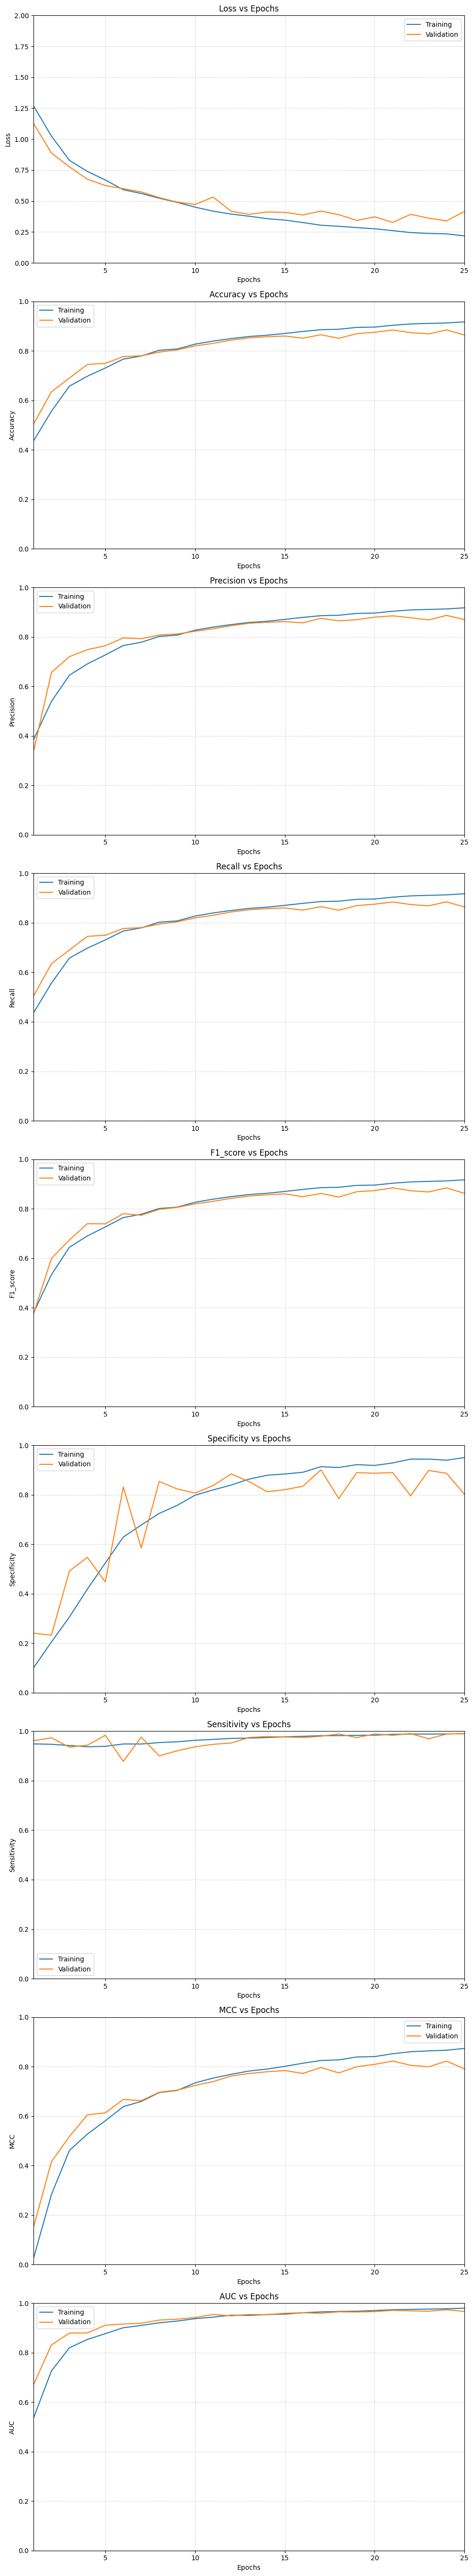

In [20]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [21]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 133/133 [00:13<00:00, 10.23it/s]

Metrics - loss: 0.4609, accuracy: 0.8432, precision: 0.8520, recall: 0.8432, f1_score: 0.8410, specificity: 0.8011, sensitivity: 0.9863, mcc: 0.7588, auc: 0.9616


In [22]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                 precision    recall  f1-score   support

          COVID     0.9236    0.8011    0.8580       362
   Lung_Opacity     0.8675    0.7188    0.7862       601
         Normal     0.8003    0.9441    0.8663      1019
Viral Pneumonia     0.9806    0.7481    0.8487       135

       accuracy                         0.8432      2117
      macro avg     0.8930    0.8030    0.8398      2117
   weighted avg     0.8520    0.8432    0.8410      2117

There were 332 errors in 2117 tests for an accuracy of  84.32


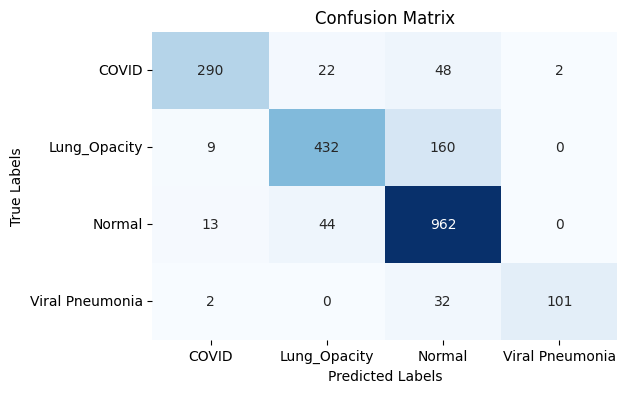

In [23]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()